In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

train = pd.read_json(r"C:\JupyterNotebooks\Two Sigma\train.json")

# train = train[5000:]
# target = train[:5000]


In [2]:
# target = target.set_index('listing_id')
train = train.set_index('listing_id')
print (f'There are {train.shape[0]} rows and {train.shape[1]} attributes.')
# print (f'There are {target.shape[0]} rows and {target.shape[1]} attributes.')

There are 49352 rows and 14 attributes.


In [3]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn.metrics import accuracy_score
import time

# train = pd.read_json(r"C:\JupyterNotebooks\Two Sigma\train.json")
# test = pd.read_json(r"C:\JupyterNotebooks\Two Sigma\test.json")
# print (f'There are {train.shape[0]} rows and {train.shape[1]} attributes.')
# print (f'There are {test.shape[0]} rows and {test.shape[1]} attributes.')

def pre_processing(data):
       
    data['nb_images'] = data['photos'].apply(len)
    data['nb_features'] = data['features'].apply(len)
    data['nb_description'] = data['description'].apply(lambda x: len(x.split(' ')))
    data['description_len'] = data['description'].apply(len)
    
    def room_price(x, y):
        if y == 0:
            return 0
        return x/y
    
    def sentiment_analysis(x):
        if len(x) == 0:
            return 0
        return TextBlob(x[0]).sentiment.polarity
    
    data = data.join(data['description'].apply(
                         lambda x: TextBlob(x).sentiment.polarity).rename('sentiment'))
    data['price_room'] = data.apply(lambda row: 
                                    room_price(row['price'],row['bedrooms']), axis=1)
       
    return data

def print_scores(test_name, train, test):
    print ('{0} train score: {1}\n{0} test score: {2}\n'.format(test_name,
                                                               train,
                                                               test))



In [4]:
processed_train_data = pre_processing(train)
# processed_target_data = pre_processing(target)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

[0.0186459  0.01805644 0.14115043 0.11466895 0.10907629 0.11117747
 0.09195093 0.08790549 0.10161844 0.1055476  0.10020207]


(<Figure size 936x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a5388f9048>)

Text(0.5,1,'Feature ranking')

Text(0,0.5,'Importance degree')

Text(0.5,0,'Features')

([<matplotlib.axis.XTick at 0x1a5388ee4a8>,
 <a list of 11 Text xticklabel objects>)

<BarContainer object of 11 artists>

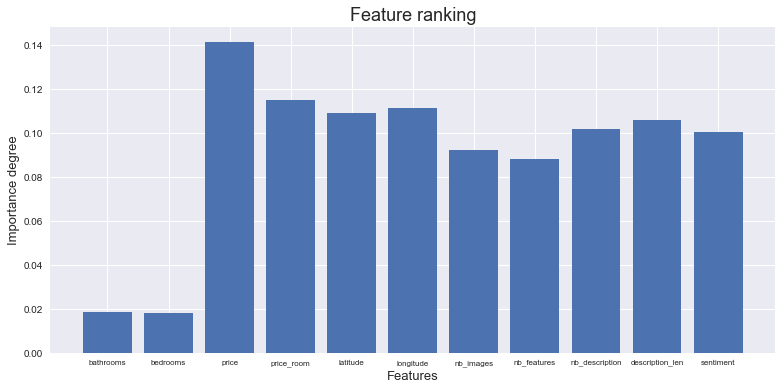

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

numerical_features = processed_train_data[['bathrooms', 'bedrooms', 'price', 'price_room',
                            'latitude','longitude', 'nb_images','nb_features', 
                            'nb_description', 'description_len','sentiment']]

# Fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(numerical_features, processed_train_data['interest_level'])

# Display the relative importance of each attribute
print (model.feature_importances_)

# Plot feature importance
plt.subplots(figsize=(13, 6))
plt.title('Feature ranking', fontsize = 18)
plt.ylabel('Importance degree', fontsize = 13)
plt.xlabel("Features", fontsize = 13)

feature_names = numerical_features.columns
plt.xticks(range(numerical_features.shape[1]), feature_names, fontsize = 8)
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [6]:
global important_features
important_features = ['bathrooms', 'bedrooms', 'price', 'price_room',
                      'latitude','longitude', 'nb_images','nb_features',
                      'sentiment', 'nb_description', 'description_len']

In [7]:

train_data = processed_train_data
# target_data = processed_target_data

test_size=0.2
random_state=19

# Split data into X and y

X = train_data[important_features]
y = train_data['interest_level']
y.columns = ['interest_level']    

# X_target = train_data[important_features]
# y_target = train_data['interest_level']
# y_target.columns = ['interest_level']  


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=random_state)

# Support vector machine
svm_model = svm.SVC(decision_function_shape='ovo', tol=0.00000001)
svm_model = svm_model.fit(X_train, y_train)
print_scores("Support Vector Machine",
             svm_model.score(X_train, y_train),
             accuracy_score(y_test, svm_model.predict(X_test)))

# Random Forest
random_forest = RandomForestClassifier(n_estimators=10)
random_forest = random_forest.fit(X_train, y_train)
print_scores("Random Forest",
             random_forest.score(X_train, y_train),
             accuracy_score(y_test, random_forest.predict(X_test)))

# GradientBoostingClassifier
gradientB_model = GradientBoostingClassifier(n_estimators=20,
                                  learning_rate=1.0,
                                  max_depth=1,
                                  random_state=0).fit(X_train, y_train)
gradientB_model = gradientB_model.fit(X_train, y_train)
print_scores("Gradient Boosting Classifier",
             gradientB_model.score(X_train, y_train),
             accuracy_score(y_test, gradientB_model.predict(X_test)))

Support Vector Machine train score: 0.969251032142043
Support Vector Machine test score: 0.7070205652922703

Random Forest train score: 0.9620323700007598
Random Forest test score: 0.7176577854320737

Gradient Boosting Classifier train score: 0.7040095235682987
Gradient Boosting Classifier test score: 0.704386586971938

